# <a id='toc1_'></a>[Trading Strategy](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Trading Strategy](#toc1_)    
- [Import libraries](#toc2_)    
- [Import data](#toc3_)    
- [10-1 portfolio](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Import libraries](#toc0_)

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

from pathlib import Path
import sys
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))
from libs.functions import *

plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})

# <a id='toc3_'></a>[Import data](#toc0_)

In [2]:
preds = pd.read_csv('data/predictions.csv')
preds.rename(columns={'Unnamed: 0': 'index_original'}, inplace=True)
preds.columns = preds.columns.str.lower()
preds['timestamp'] = pd.to_datetime(preds['timestamp']) + pd.offsets.MonthEnd(1) # add one month as the target is the prediction for the next month
# preds['y_true'] = preds['y_true'] + ((1+preds['discount'])**(1/12)-1) # add back the short rate to get the true return

data_raw = pd.read_csv('data/data.csv')
discount = data_raw[['timestamp', 'discount']].copy()
discount['timestamp'] = pd.to_datetime(discount['timestamp'])
discount['discount_m'] = (1 + discount['discount'])**(1/12) - 1

omxc25_tickers = pd.read_csv('data/omxc25_constit.csv')
omxc25_tickers = omxc25_tickers[['timestamp', 'ticker']]
omxc25_tickers['in_c25'] = True
omxc25_tickers['timestamp'] = pd.to_datetime(omxc25_tickers['timestamp'])

omxc25_price = pd.read_csv('data/omxc25_price.csv')
omxc25_price['timestamp'] = pd.to_datetime(omxc25_price['timestamp'])
omxc25_price = omxc25_price[(omxc25_price['timestamp'] >= '2021-01-01') & (omxc25_price['timestamp'] <= '2024-12-31')]

omxcb_tickers = pd.read_csv('data/omxcb_constit.csv')
omxcb_tickers = omxcb_tickers[['timestamp', 'ticker']]
omxcb_tickers['timestamp'] = pd.to_datetime(omxcb_tickers['timestamp'])
omxcb_tickers['in_cb'] = True 

omxcb_price = pd.read_csv('data/omxcb_price.csv')
omxcb_price['timestamp'] = pd.to_datetime(omxcb_price['timestamp'])
omxcb_price = omxcb_price[(omxcb_price['timestamp'] >= '2021-01-01') & (omxcb_price['timestamp'] <= '2024-12-31')]

In [3]:
df = (preds
      .merge(omxc25_tickers, on=['ticker','timestamp'], how='left')
      .merge(omxcb_tickers, on=['ticker','timestamp'], how='left')
)
df['in_c25'] = np.where(df['in_c25'].isna(), False, df['in_c25'])
df['in_cb'] = np.where(df['in_cb'].isna(), False, df['in_cb'])

# df = df[df['in_cb'] == True]
df = df[df['in_c25'] == True]

# <a id='toc4_'></a>[10-1 portfolio](#toc0_)

In [4]:
# # make excess returns
# # plot long and short separately (similar to gu)
# # Make tables similar to gu pp 2266-2267

# # create deciles
# df['decile_ols'] = df.groupby(['timestamp'])['ols'].transform(deciles)
# df['decile_lasso'] = df.groupby(['timestamp'])['lasso'].transform(deciles)
# df['decile_mlp'] = df.groupby(['timestamp'])['mlp'].transform(deciles)
# df['decile_mlp-pyr'] = df.groupby(['timestamp'])['mlp-pyr'].transform(deciles)


In [5]:
# # calculate portfolio returns
# df.sort_values(by=['timestamp'])
# port_10_1 = pd.DataFrame()
# models = {
#     'ols':      'decile_ols',
#     'lasso':    'decile_lasso',
#     'mlp':      'decile_mlp',
#     'mlp-pyr':  'decile_mlp-pyr'
# }

# tmp_dfs = {}

# for model, decile in models.items():
#     tmp = df.copy(deep=True)
#     tmp = tmp[['timestamp', 'ticker', decile, 'y_true']]
    
#     tmp['action'] = np.where(tmp[decile] == 0, -1, np.where(tmp[decile] == 9, 1, 0))


#     tmp['n_short'] = (tmp['action'] == -1).astype(int)
#     tmp['n_long'] = (tmp['action'] == 1).astype(int)


#     tmp['n_short'] = tmp.groupby('timestamp')['n_short'].transform('sum')
#     tmp['n_long'] = tmp.groupby('timestamp')['n_long'].transform('sum')

#     tmp[f'{model}_return'] = np.where(tmp['action'] == 1, tmp['y_true']/tmp['n_long'],
#                             np.where(tmp['action'] == -1, - tmp['y_true']/tmp['n_short'], 0))

#     tmp_df = tmp.copy(deep=True)
#     # drop rows with action == 0
#     tmp_df = tmp_df[tmp_df['action'] != 0]
#     tmp_dfs[model] = tmp_df
    
#     tmp = tmp.groupby('timestamp')[f'{model}_return'].sum().reset_index()
#     tmp[f'{model}_return'] = tmp[f'{model}_return'] + 1
#     tmp[f'{model}_return_cum'] = tmp[f'{model}_return'].cumprod() * 100
#     tmp[f'{model}_return'] = tmp[f'{model}_return'] - 1

#     port_10_1 = pd.concat([port_10_1, tmp], axis=1)
# port_10_1 = port_10_1.loc[:, ~port_10_1.columns.duplicated()]
# port_10_1.loc[-1] = [pd.Timestamp('2021-01-01'), 0, 100, 0, 100, 0, 100, 0, 100]
# port_10_1 = port_10_1.sort_index().reset_index(drop=True)


In [6]:
# calculate portfolio returns
df.sort_values(by=['timestamp'])
port_10_1 = pd.DataFrame()
models = ['ols','lasso','mlp','mlp-pyr']

for model in models:
    for dir in ['long', 'short']:
        tmp = df.copy(deep=True)
        tmp = tmp[['timestamp', model, 'y_true']]
        tmp['decile'] = df.groupby(['timestamp'])[model].transform(deciles)
        # create action column based on decile
        if dir == 'long':
            tmp['action'] = np.where(tmp['decile'] == 9, 1, 0)
        else:
            tmp['action'] = np.where(tmp['decile'] == 0, -1, 0)
        # find stocks in position
        tmp[f'n_dir'] = (tmp['action'] == (1 if dir == 'long' else -1)).astype(int)
        tmp[f'n_dir'] = tmp.groupby('timestamp')[f'n_dir'].transform('sum')
        
        # calculate return for the direction (equal weighted)  
        tmp[f'{model}_{dir}'] = tmp['action']*tmp['y_true']/tmp[f'n_dir'] # multiply by action to get the return for the direction

        # sum the returns for each month
        tmp = tmp.groupby('timestamp')[f'{model}_{dir}'].sum().reset_index()
        # calculate cumulative return and percentage return
        tmp[f'{model}_{dir}'] = tmp[f'{model}_{dir}'] + 1
        tmp[f'{model}_{dir}_cum'] = tmp[f'{model}_{dir}'].cumprod() * 100
        tmp[f'{model}_{dir}'] = tmp[f'{model}_{dir}'] - 1

        port_10_1 = pd.concat([port_10_1, tmp], axis=1)
port_10_1 = port_10_1.loc[:, ~port_10_1.columns.duplicated()]
# start with an initial value of 100
port_10_1.loc[-1] = [pd.Timestamp('2021-01-01'), np.nan, 100, np.nan, 100, np.nan, 100, np.nan, 100, np.nan, 100, np.nan, 100, np.nan, 100, np.nan, 100]
port_10_1 = port_10_1.sort_index().reset_index(drop=True)


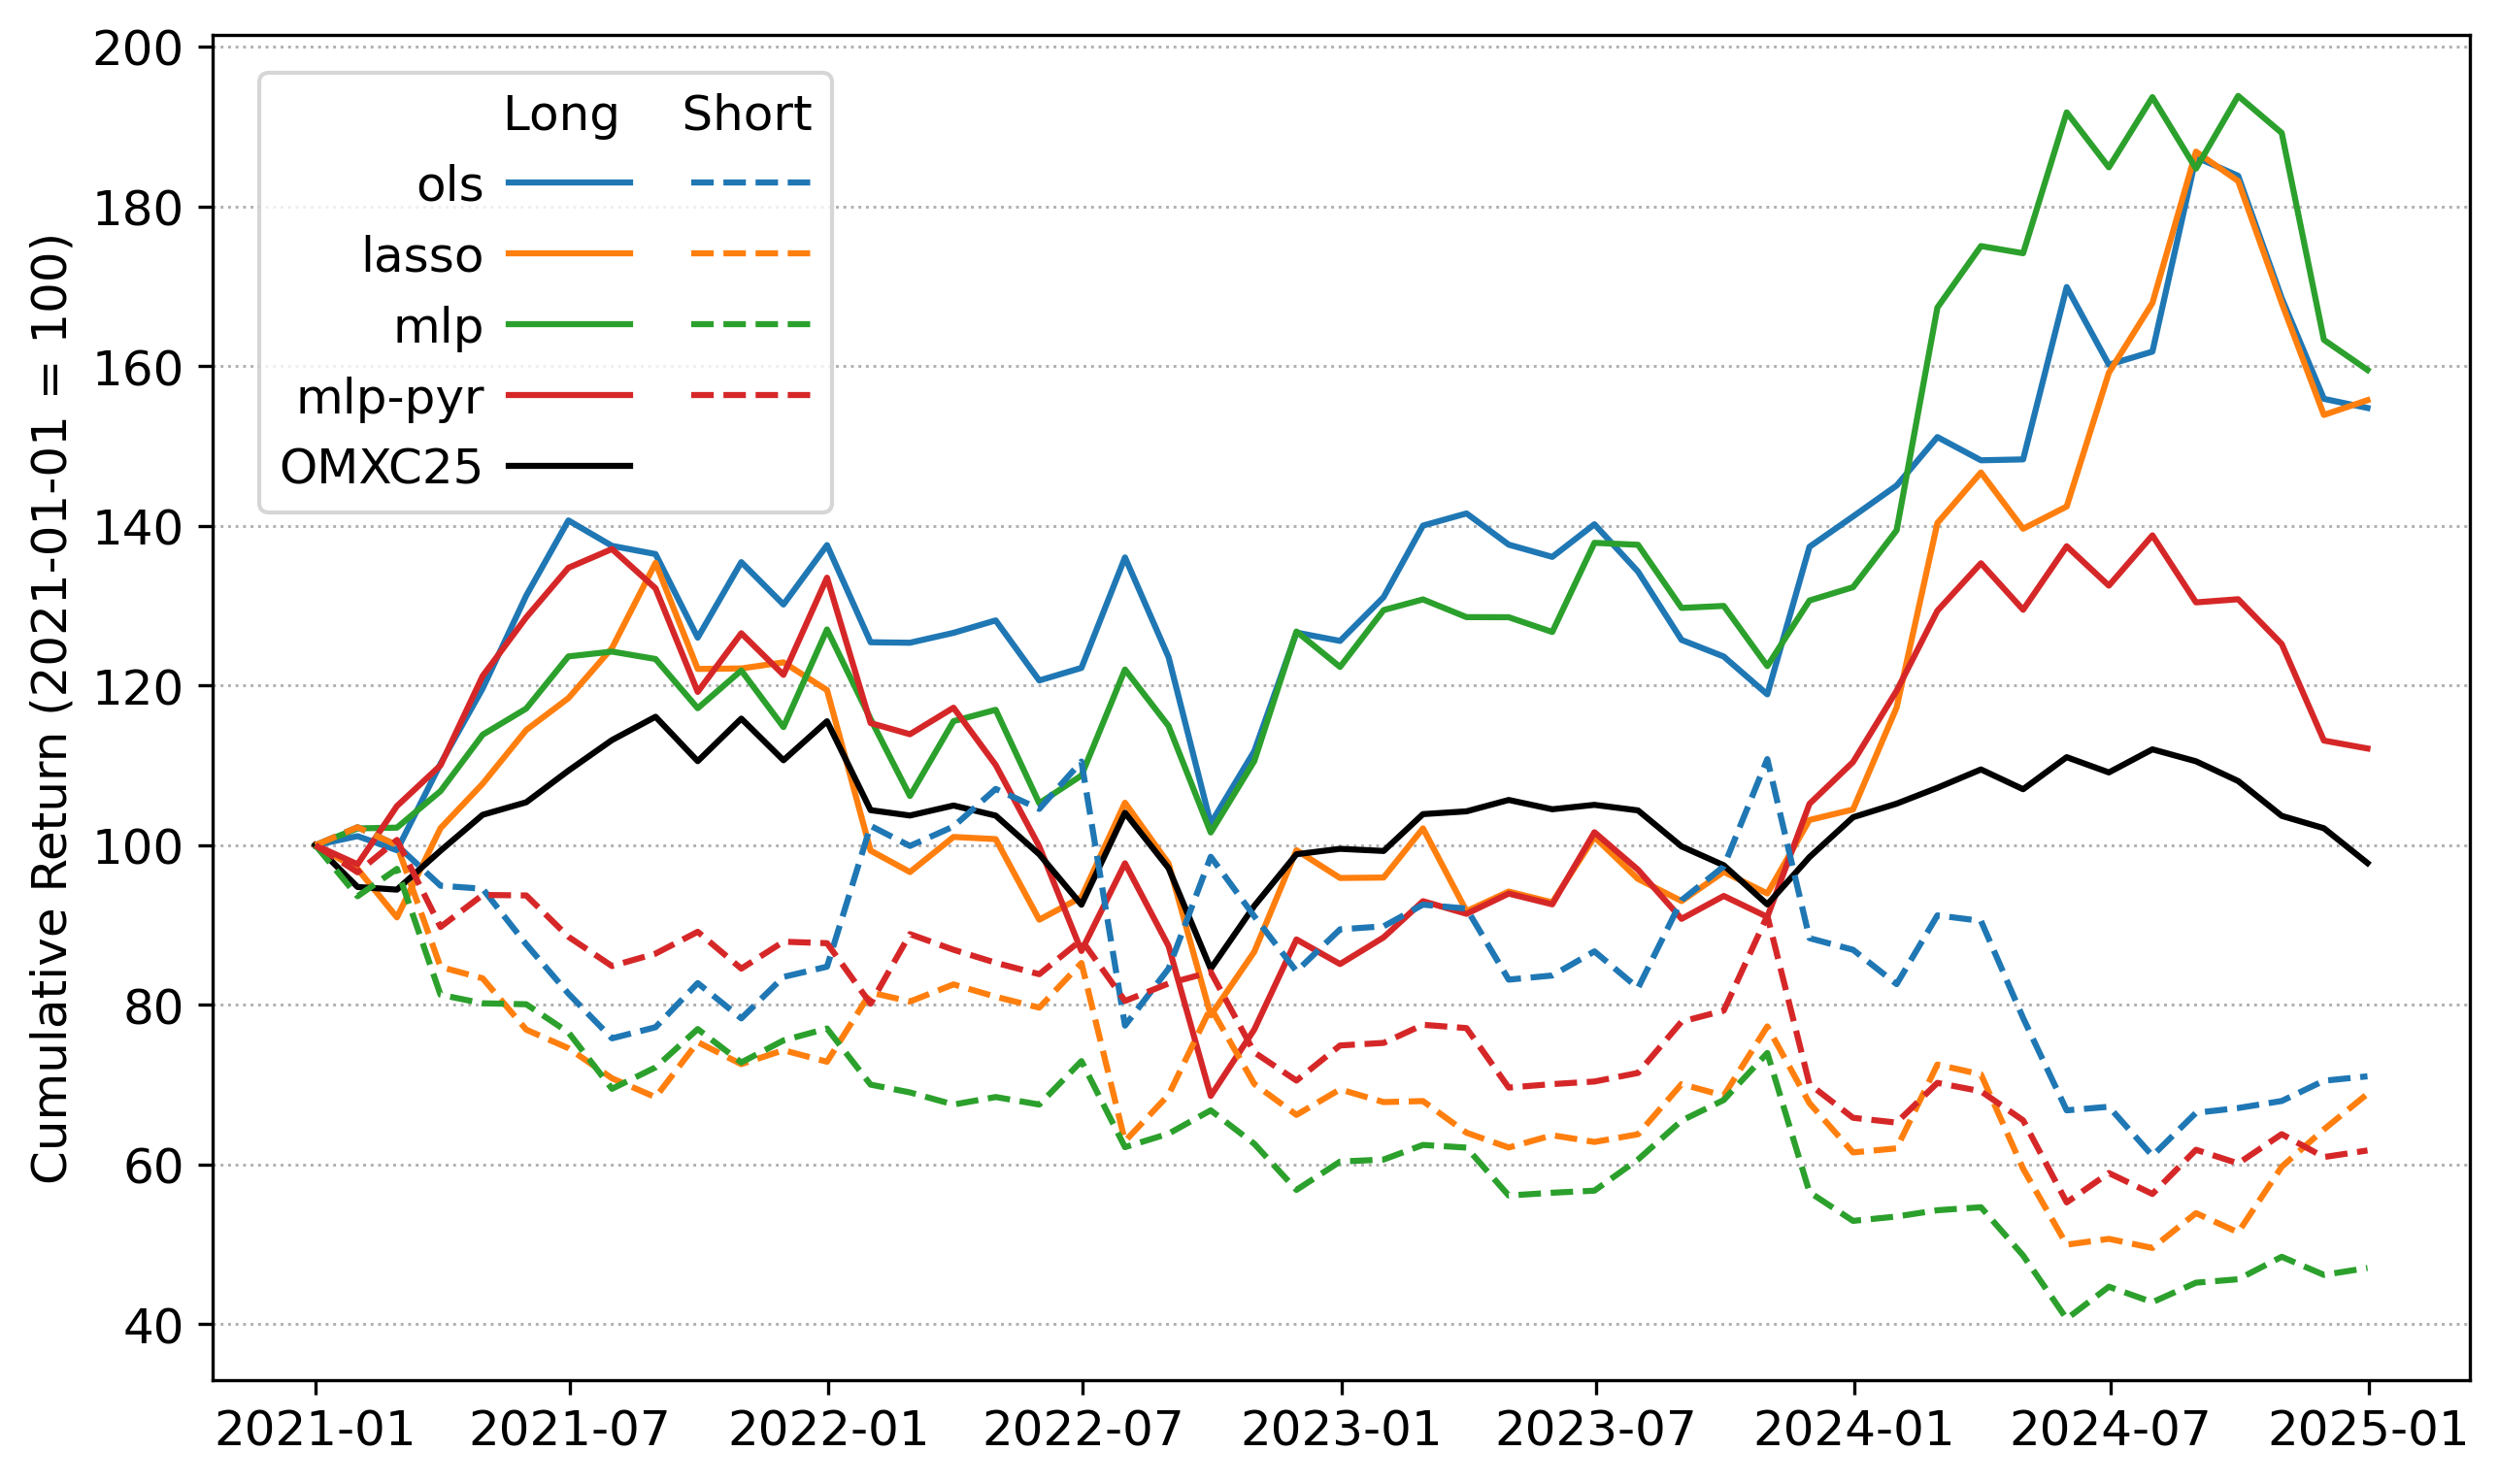

In [7]:
# plotting
fig, ax = plt.subplots(figsize=(10, 6))
default_cycler = plt.rcParams['axes.prop_cycle']
for model in models:    
    ax.plot(port_10_1['timestamp'], port_10_1[f'{model}_long_cum'], label=f'{model}', linestyle='-')
ax.plot(omxc25_price['timestamp'], omxc25_price['cumulative'], label='OMXC25', linestyle='-', color='black')
ax = plt.gca()
ax.set_prop_cycle(default_cycler)
for model in models:    
    ax.plot(port_10_1['timestamp'], port_10_1[f'{model}_short_cum'], label=f' ', linestyle='--')
ax.set_ylabel('Cumulative Return (2021-01-01 = 100)')
ax.yaxis.grid(True, which='major', linestyle=':', linewidth=0.7)

leg = ax.legend(ncol=2, loc='upper left',frameon=True, markerfirst=False, handlelength=2.5,handletextpad=0.5, bbox_to_anchor=(0.01, 0.99, 0.275 ,0.0), mode='expand', title='Long    Short')
leg._legend_box.align = "right"

plt.savefig('figs/port10-1_return.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [8]:
preds = df.copy(deep=True)
preds = preds[['timestamp', 'ticker', 'y_true', 'ols', 'lasso', 'mlp', 'mlp-pyr']]
preds.reset_index(inplace=True, drop=True)
preds

,timestamp,ticker,y_true,ols,lasso,mlp,mlp-pyr
0,2021-01-31,AMBUb.CO,0.103723,0.104189,0.044750,0.037385,0.034357
1,2021-02-28,AMBUb.CO,-0.017556,0.077836,0.045666,0.016172,0.021035
2,2021-03-31,AMBUb.CO,0.043798,0.106162,0.057592,0.025162,0.026539
3,2021-04-30,AMBUb.CO,0.163478,0.119212,0.051118,0.031594,0.029331
4,2021-05-31,AMBUb.CO,-0.345066,0.101418,0.040671,0.023824,0.024915
...,...,...,...,...,...,...,...
1132,2024-08-31,ZELA.CO,-0.049524,0.013537,0.048972,0.009181,0.008057
1133,2024-09-30,ZELA.CO,-0.085660,-0.032799,0.031151,0.007395,0.008777
1134,2024-10-31,ZELA.CO,-0.030425,-0.041963,0.023751,0.007448,0.007291
1135,2024-11-30,ZELA.CO,-0.079081,-0.050598,0.022060,0.010207,0.006718


In [9]:
import numpy as np
import pandas as pd

# -------------------------------------------------------------------
# Assumes `preds` DataFrame is already defined with columns:
#   ['timestamp', 'ticker', 'y_true', 'ols', 'lasso', 'mlp', 'mlp-pyr']
# -------------------------------------------------------------------

# 1. Prepare asset-level returns matrix for turnover
asset_ret = (
    preds
    .pivot_table(
        index='timestamp',
        columns='ticker',
        values='y_true',
        aggfunc='mean'
    )
    .fillna(0)
)

# 2. Set up
models     = ['ols', 'lasso', 'mlp', 'mlp-pyr']
n_deciles  = 10

# 3. Helper functions
def assign_decile(df, model):
    return (
        df.groupby('timestamp')[model]
          .transform(lambda x: pd.qcut(x, n_deciles, labels=False) + 1)
    )

def max_drawdown(r):
    """Max drawdown of a return series (as decimal)."""
    wealth = (1 + r).cumprod()
    peak   = wealth.cummax()
    dd     = (peak - wealth) / peak
    return dd.max()

def turnover_exact(weights_df, asset_ret_df):
    """
    Exact turnover per Gu et al.:
      weights_df: DataFrame indexed by timestamp, cols=ticker, weights at t
      asset_ret_df: DataFrame indexed by timestamp, cols=ticker, returns at t
    """
    to_list = []
    dates = weights_df.index
    for i in range(len(dates) - 1):
        t0, t1 = dates[i], dates[i+1]
        w_old = weights_df.loc[t0]
        w_new = weights_df.loc[t1]
        r     = asset_ret_df.loc[t1]
        R     = (w_old * r).sum()
        scaled_old = w_old * (1 + r) / (1 + R)
        to_list.append(0.5 * np.abs(w_new - scaled_old).sum())
    return np.mean(to_list) * 100  # percent

# 4. Assign deciles to preds
preds['timestamp'] = pd.to_datetime(preds['timestamp'])
preds = preds.sort_values('timestamp')
for m in models:
    preds[f'dec_{m}'] = assign_decile(preds, m)

# 5. Table 7: Decile-by-decile performance
tbl7 = {}
for m in models:
    recs = []
    for d in range(1, n_deciles + 1):
        grp = preds[preds[f'dec_{m}'] == d]
        r   = grp['y_true']
        avg = r.mean()
        sd  = r.std(ddof=1)
        sr  = avg / sd * np.sqrt(12)
        p   = grp[m].mean()
        recs.append({'decile': d, 'Pred': p, 'Avg': avg, 'SD': sd, 'SR': sr})
    df7 = pd.DataFrame(recs).set_index('decile')
    hi, lo = df7.loc[n_deciles], df7.loc[1]
    hl = hi - lo; hl.name = 'H-L'
    tbl7[m] = pd.concat([
        df7,
        pd.DataFrame([hi], index=['High']),
        pd.DataFrame([lo], index=['Low']),
        pd.DataFrame([hl])
    ])

# 6. Table 8: Drawdowns, turnover
tbl8 = {}
for m in models:
    # build VW returns for deciles
    vw = {}
    for d in [1, n_deciles]:
        grp = preds[preds[f'dec_{m}'] == d]
        w_raw = grp['y_true'].abs()
        w = w_raw / w_raw.sum()
        vw[d] = (w * grp['y_true']).groupby(grp['timestamp']).sum().sort_index()

    stats = {}
    for label, series in [('Low', vw[1]), ('High', vw[n_deciles])]:
        d = 1 if label == 'Low' else n_deciles
        weights_df = (
            preds[preds[f'dec_{m}'] == d]
            .pivot_table(index='timestamp', columns='ticker',
                         values='y_true', aggfunc='mean')
            .abs()
        )
        weights_df = weights_df.div(weights_df.sum(axis=1), axis=0)
        stats[label] = {
            'Max DD (%)':      100 * max_drawdown(series),
            'Max 1M loss (%)': -100 * series.min(),
            'Turnover (%)':    turnover_exact(weights_df, asset_ret)
        }
    tbl8[m] = pd.DataFrame(stats).T

# 7. Display results
for m in models:
    print(f"\n=== Model: {m} ===")
    print("\nTable 7:")
    print(tbl7[m].round(4))
    print("\nTable 8:")
    print(tbl8[m].round(4))



=== Model: ols ===

Table 7:
        Pred     Avg      SD      SR
1    -0.0422  0.0028  0.1131  0.0865
2    -0.0208 -0.0010  0.0862 -0.0411
3    -0.0137  0.0143  0.1157  0.4274
4    -0.0118  0.0106  0.1025  0.3569
5     0.0034 -0.0066  0.0947 -0.2408
6     0.0115  0.0021  0.0827  0.0886
7     0.0131 -0.0087  0.0934 -0.3214
8     0.0272 -0.0065  0.0794 -0.2843
9     0.0401  0.0063  0.1077  0.2042
10    0.0633  0.0116  0.1021  0.3922
High  0.0633  0.0116  0.1021  0.3922
Low  -0.0422  0.0028  0.1131  0.0865
H-L   0.1055  0.0087 -0.0110  0.3056

Table 8:
      Max DD (%)  Max 1M loss (%)  Turnover (%)
Low       1.8615           1.2975       21.9612
High      1.2831           0.8502       21.2843

=== Model: lasso ===

Table 7:
        Pred     Avg      SD      SR
1    -0.0205  0.0037  0.1223  0.1051
2    -0.0111 -0.0092  0.0864 -0.3707
3    -0.0066  0.0096  0.0873  0.3812
4    -0.0071  0.0059  0.1053  0.1928
5     0.0017 -0.0066  0.0880 -0.2605
6     0.0036  0.0012  0.1026  0.0411
7     0

# Sign-only

In [10]:
# port_directional = pd.DataFrame()

# for model in models.keys():
#     tmp = df.copy(deep=True)
#     tmp['action'] = np.where(np.sign(tmp[model]) == 1, 1, np.where(np.sign(tmp[model]) == -1, -1, 0))
#     tmp['action'] = np.where(np.sign(tmp[model]) == 1, 1, -1)

#     tmp['n_short'] = (tmp['action'] == -1).astype(int)
#     tmp['n_long'] = (tmp['action'] == 1).astype(int)

#     tmp['n_short'] = tmp.groupby('timestamp')['n_short'].transform('sum')
#     tmp['n_long'] = tmp.groupby('timestamp')['n_long'].transform('sum')


#     tmp[f'{model}_return'] = np.where(tmp['action'] == 1, tmp['y_true']/tmp['n_long'],
#                         np.where(tmp['action'] == -1, - tmp['y_true']/tmp['n_short'], 0))
#     # pure one directional strategy
#     # tmp[f'{model}_return'] = np.where(tmp['action'] == 1, tmp['y_true']/tmp['n_long'],0)
#     # tmp[f'{model}_return'] = np.where(tmp['action'] == -1, - tmp['y_true']/tmp['n_short'],0)

#     tmp = tmp.groupby('timestamp')[f'{model}_return'].sum().reset_index()
#     tmp[f'{model}_return'] = tmp[f'{model}_return'] + 1
#     tmp[f'{model}_return_cum'] = tmp[f'{model}_return'].cumprod() * 100
#     tmp[f'{model}_return'] = tmp[f'{model}_return'] - 1
    
#     port_directional = pd.concat([port_directional, tmp], axis=1)
# port_directional = port_directional.loc[:, ~port_directional.columns.duplicated()]
# port_directional.loc[-1] = [pd.Timestamp('2021-01-01'), 0, 100, 0, 100, 0, 100, 0, 100]
# port_directional = port_directional.sort_index().reset_index(drop=True)

In [11]:
# # plotting
# plt.figure(figsize=(10, 6))
# for model in models.keys():
#     plt.plot(port_directional['timestamp'], port_directional[f'{model}_return_cum'], label=model)
# plt.plot(omxc25_price['timestamp'], omxc25_price['cumulative'], label='OMXC25', linestyle='--')
# # plt.plot(omxcb_price['timestamp'], omxcb_price['cumulative'], label='OMXCB', linestyle='--')
# # plt.title('Cumulative Returns by Model')
# # plt.xlabel('Timestamp')
# plt.ylabel('Cumulative Return (2021-01-01 = 100)')
# plt.legend()
# plt.tight_layout()
# plt.show()
# plt.close()